In [7]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
pip install git+https://github.com/huggingface/accelerate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-gt1jf72u
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-gt1jf72u
  Resolved https://github.com/huggingface/accelerate to commit 5904f56c45914a8719139abe48da4e0c03113f0f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Импортим библиотеки

In [10]:
import random
import torch
import transformers
import re
import warnings
import sys

import pandas as pd
import numpy as np
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

# from text_preprocessing_utils import RemoveWeb, CleanTexts
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EvalPrediction
# from datasets import load_metric, Dataset
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
from typing import List
from tqdm import tqdm
from torch.utils.data import Dataset
import wandb

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Необходимо чтобы не было случайности

In [12]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
seed_all(42)

Обработка датасета

In [13]:
df = pd.read_csv("/content/gdrive/My Drive/cryptonews.csv")
df['sentiment'] = df['sentiment'].apply(lambda x: x.replace("'", ""))
df['sentiment'] = df['sentiment'].apply(lambda x: x.split(':')[1])
df['sentiment'] = df['sentiment'].apply(lambda x: x.split(',')[0]) 
df['sentiment'] = df['sentiment'].apply(lambda x: x.replace(" ", ""))

In [14]:
df['sentiment'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

Проверка на дисбаланс классов

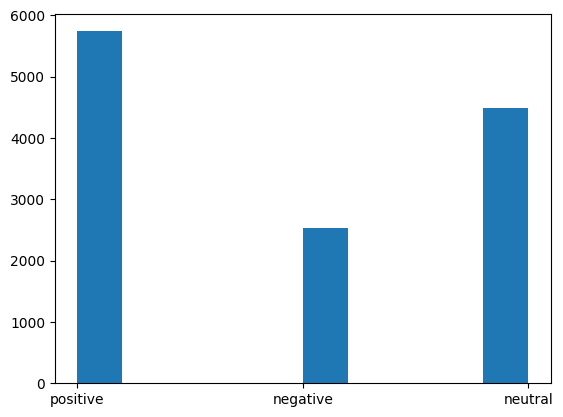

In [15]:
plt.hist(df['sentiment'])
plt.show()

Подключаем куду

In [16]:
DEVICE = torch.device("cuda")

Берем берта

In [17]:
bert = 'ahmedrachid/FinancialBERT-Sentiment-Analysis'

In [18]:
id2label = {0: 'negative', 1: 'positive', 2: 'neutral'}
label2id = {'negative': 0, 'positive': 1, 'neutral': 2}
LABELS = [
    'positive',
    'negative',
    'neutral'
]

Инициализация берта

In [19]:
tokenizer = BertTokenizer.from_pretrained(bert)
model = BertForSequenceClassification.from_pretrained(
    bert,
    problem_type="multi_label_classification",
    num_labels=3, 
    id2label=id2label, 
    label2id=label2id
).to(DEVICE)

In [20]:
X = df['text']
y = df['sentiment']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

train_df = pd.DataFrame({'text': X_train, 'target': y_train})
train_labels = train_df['target'].values
test_df = pd.DataFrame({'text': X_test, 'target': y_test})
test_labels = test_df['target'].values
val_df = pd.DataFrame({'text': X_val, 'target': y_val})
val_labels = val_df['target'].values

In [21]:
test_df['target'] = test_df['target'].replace(label2id)
train_df['target'] = train_df['target'].replace(label2id)
val_df['target'] = val_df['target'].replace(label2id)

In [22]:
test_labels = test_df['target'].values
train_labels = train_df['target'].values
val_labels = val_df['target'].values

In [23]:
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)

In [24]:
tokens_train = tokenizer.batch_encode_plus(
    train_df['text'].values,
    padding='max_length',
    max_length=512,
    truncation=True
)
tokens_test = tokenizer.batch_encode_plus(
    test_df['text'].values,
    padding='max_length',
    max_length=512,
    truncation=True
)
tokens_val = tokenizer.batch_encode_plus(
    val_df['text'].values,
    padding='max_length',
    max_length=512,
    truncation=True
)

In [25]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, unique_labels):
        self.encodings = encodings
        self.labels = labels
        self.unique_labels = unique_labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        labels = self.unique_labels * [0]
        labels[self.labels[idx]] = 1
        item["labels"] = torch.tensor(labels).float()
        return item

    def __len__(self):
        return len(self.labels)


In [26]:
train_dataset = Data(tokens_train, train_labels, 3)
test_dataset = Data(tokens_test, test_labels, 3)
val_dataset = Data(tokens_val, val_labels, 3)

In [27]:
training_args = TrainingArguments(
    output_dir='./results', #Выходной каталог
    num_train_epochs=5, #Кол-во эпох для обучения
    per_device_train_batch_size=8, #Размер батча для каждого устройства во время обучения
    per_device_eval_batch_size=8, #Размер батча для каждого устройства во время валидации
    weight_decay=0.01, #Понижение весов
    load_best_model_at_end=True, #Загружать ли лучшую модель после обучения
    learning_rate=2e-5, #Скорость обучения
    evaluation_strategy='epoch', #Валидация после каждой эпохи (можно сделать после конкретного кол-ва шагов)
    save_strategy='epoch', #Сохранение после каждой эпохи
    save_total_limit=1,
    seed=21
)

In [28]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [29]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)                                                                                                                                                

In [30]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.521000,0.321490,0.810650,0.856569,0.799608
2,0.260900,0.293366,0.848089,0.884706,0.838039
3,0.174300,0.314150,0.859341,0.893627,0.852941
4,0.100000,0.350502,0.875320,0.905784,0.871373
5,0.069500,0.381186,0.870472,0.902255,0.866275


TrainOutput(global_step=4785, training_loss=0.2112249790937051, metrics={'train_runtime': 3987.6367, 'train_samples_per_second': 9.592, 'train_steps_per_second': 1.2, 'total_flos': 1.0064088228096e+16, 'train_loss': 0.2112249790937051, 'epoch': 5.0})

In [31]:
wandb.finish()

eval/accuracy,▁▅▆██
eval/f1,▁▅▆█▇
eval/loss,▃▁▃▆█
eval/roc_auc,▁▅▆█▇
eval/runtime,▁█▄▇█
eval/samples_per_second,█▁▅▂▁
eval/steps_per_second,█▁▅▂▁
train/epoch,▁▂▂▃▃▃▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▃▄▅▅▆▆▇███
train/learning_rate,█▇▆▅▅▄▃▂▁
train/loss,█▆▄▄▃▂▁▁▁


In [32]:
trainer.save_model("cryptobert")

In [33]:
tokenizer = BertTokenizer.from_pretrained('cryptobert')
model_loaded = BertForSequenceClassification.from_pretrained("cryptobert")
trainer = Trainer(model=model_loaded)

In [34]:
def get_prediction():
    test_pred = trainer.predict(test_dataset)
    labels = np.argmax(test_pred.predictions, axis = -1)
    return labels

In [35]:
pred = get_prediction()
f1_micro_average = f1_score(y_true=test_labels, y_pred=pred, average='micro')
accuracy = accuracy_score(test_labels, pred)
print(f'f1-score: {f1_micro_average}')
print(f'accuracy: {accuracy}')

f1-score: 0.8525490196078431
accuracy: 0.8525490196078431


In [47]:
test_df['predict'] = pd.Series(pred)

In [48]:
test_df

,text,target,predict
0,The Japanese digital asset exchange Gaia will ...,2,2
1,A Finder.com panel predicted that ADA could re...,1,1
2,The latest big name to get involved in the NFT...,1,1
3,STRAX price bucked the market-wide bearish dow...,1,1
4,'This deal continues to be a rollercoaster.',2,2
...,...,...,...
2545,Listen to what Polygon's Co-founder and COO Sa...,1,1
2546,42% of the poll participants said they don't i...,2,2
2547,Police in the Bahamas has launched an investig...,0,2
2548,Developers have seven days to fix the associat...,2,2
